# Calculate mixed land-uses.

Calculate mixed landuses from a `geopandas` `GeoDataFrame`.


In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cityseer.metrics import layers
from cityseer.tools import graphs, io


To start, follow the same approach as shown in the network examples to create the network.


In [2]:
streets_gpd = gpd.read_file("data/madrid_streets/street_network.gpkg")
streets_gpd = streets_gpd.explode(reset_index=True)
G = io.nx_from_generic_geopandas(streets_gpd)
G_dual = graphs.nx_to_dual(G)
nodes_gdf, _edges_gdf, network_structure = io.network_structure_from_nx(G_dual)

100%|██████████| 47155/47155 [00:10<00:00, 4345.39it/s]
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 1.
100%|██████████| 47129/47129 [00:00<00:00, 108206.43it/s]
INFO:cityseer.tools.graphs:Converting graph to dual.
INFO:cityseer.tools.graphs:Preparing dual nodes
100%|██████████| 47129/47129 [00:01<00:00, 23991.18it/s]
INFO:cityseer.tools.graphs:Preparing dual edges (splitting and welding geoms)
100%|██████████| 47129/47129 [02:37<00:00, 299.40it/s]
INFO:cityseer.tools.io:Preparing node and edge arrays from networkX graph.
100%|██████████| 47129/47129 [00:13<00:00, 3378.55it/s]
INFO:cityseer.graph:Edge R-tree built successfully with 104026 items.


Read-in the dataset from the source Geopackage or Shapefile Geopandas.


In [3]:
prems_gpd = gpd.read_file("data/madrid_premises/madrid_premises.gpkg")
prems_gpd.head()

,index,local_id,local_distr_id,local_distr_desc,local_neighb_id,local_neighb_desc,local_neighb_code,local_census_section_id,local_census_section_desc,section_id,section_desc,division_id,division_desc,epigraph_id,epigraph_desc,easting,northing,geometry
0,0,10003324,1,CENTRO,105,UNIVERSIDAD,5,1091,91,I,hospitality,56,food_bev,561001,RESTAURANTE,440181.6,4475586.5,POINT (440181.6 4475586.5)
1,1,10003330,1,CENTRO,105,UNIVERSIDAD,5,1115,115,R,art_rec_entert,90,creat_entert,900003,TEATRO Y ACTIVIDADES ESCENICAS REALIZADAS EN D...,440000.6,4474761.5,POINT (440000.6 4474761.5)
2,2,10003356,1,CENTRO,104,JUSTICIA,4,1074,74,I,hospitality,56,food_bev,561004,BAR RESTAURANTE,440618.6,4474692.5,POINT (440618.6 4474692.5)
3,3,10003364,1,CENTRO,104,JUSTICIA,4,1075,75,G,wholesale_retail_motor,47,retail,472401,COMERCIO AL POR MENOR DE PAN Y PRODUCTOS DE PA...,440666.6,4474909.5,POINT (440666.6 4474909.5)
4,4,10003367,1,CENTRO,106,SOL,6,1119,119,G,wholesale_retail_motor,47,retail,477701,"COMERCIO AL POR MENOR DE JOYAS, RELOJERIA Y BI...",440378.6,4474380.5,POINT (440378.6 4474380.5)


Identify or prepare any columns and land uses of interest, for which you want to compute accessibilities.


In [4]:
prems_gpd.division_desc.unique()

array(['food_bev', 'creat_entert', 'retail', 'services', 'education',
       'accommod', 'Real Estate Activities',
       'Residential Care Activities',
       'Social Services Without Accommodation',
       'Graphic Arts and Reproduction of Recorded Media',
       'Sale and Repair of Motor Vehicles and Motorcycles',
       'Decontamination and Other Waste Management Services',
       'Gambling and Betting Activities', 'sports_rec', 'health',
       'Wholesale Trade and Middlemen, Except for Motor Vehicles and Motorcycles',
       'Telecommunications',
       'Financial Services, Except Insurance and Pension Funds',
       'Associative Activities', 'Veterinary Activities',
       'Auxiliary Services to Financial Services and Insurance',
       'Insurance, Reinsurance, and Pension Funds, Except Compulsory Social Security',
       'Rental Activities',
       'Office Administrative and Other Business Support Activities',
       'Technical Services of Architecture and Engineering; Technica

Once the land use and network data has been prepared, use the [`layers.compute_mixed_uses`](https://cityseer.benchmarkurbanism.com/metrics/layers#compute-mixed-uses) method to compute accessibilities to land uses. The `landuse_column_label` should correspond to the data in the input GeoDataFrame.


In [5]:
# compute pub accessibility
distances = [100, 200, 400, 800]
nodes_gdf, prems_gpd = layers.compute_mixed_uses(
    prems_gpd,
    landuse_column_label="division_desc",
    nodes_gdf=nodes_gdf,
    network_structure=network_structure,
    distances=distances,
)

INFO:cityseer.metrics.layers:Computing mixed-use measures.
INFO:cityseer.metrics.layers:Assigning data to network.
INFO:cityseer.data:Assigning 117358 data entries to network nodes (max_dist: 400).
INFO:cityseer.data:Collected 198409 potential node assignments from data entries.
INFO:cityseer.data:Finished assigning data. 198409 assignments added to 24598 nodes.
INFO:cityseer.graph:Barriers unset and R-tree cleared.
100%|██████████| 47129/47129 [00:20<00:00, 2324.75it/s]
INFO:cityseer.config:Metrics computed for:
INFO:cityseer.config:Distance: 100m, Beta: 0.04, Walking Time: 1.25 minutes.
INFO:cityseer.config:Distance: 200m, Beta: 0.02, Walking Time: 2.5 minutes.
INFO:cityseer.config:Distance: 400m, Beta: 0.01, Walking Time: 5.0 minutes.
INFO:cityseer.config:Distance: 800m, Beta: 0.005, Walking Time: 10.0 minutes.


The output columns are named `cc_{key}_{distance}_{type}`. Where the keys will correspond to the [form of mixed-use measure](https://cityseer.benchmarkurbanism.com/metrics/layers#notes-2) and the distances will correspond to the input distances. The measures are available in non-weighted `nw` or distance weighted `wt` form.

Standard GeoPandas functionality can be used to explore, visualise, or save the results.


In [6]:
nodes_gdf.columns

Index(['ns_node_idx', 'x', 'y', 'live', 'weight', 'primal_edge',
       'primal_edge_node_a', 'primal_edge_node_b', 'primal_edge_idx',
       'dual_node', 'cc_hill_q0_100_nw', 'cc_hill_q0_100_wt',
       'cc_hill_q1_100_nw', 'cc_hill_q1_100_wt', 'cc_hill_q2_100_nw',
       'cc_hill_q2_100_wt', 'cc_hill_q0_200_nw', 'cc_hill_q0_200_wt',
       'cc_hill_q1_200_nw', 'cc_hill_q1_200_wt', 'cc_hill_q2_200_nw',
       'cc_hill_q2_200_wt', 'cc_hill_q0_400_nw', 'cc_hill_q0_400_wt',
       'cc_hill_q1_400_nw', 'cc_hill_q1_400_wt', 'cc_hill_q2_400_nw',
       'cc_hill_q2_400_wt', 'cc_hill_q0_800_nw', 'cc_hill_q0_800_wt',
       'cc_hill_q1_800_nw', 'cc_hill_q1_800_wt', 'cc_hill_q2_800_nw',
       'cc_hill_q2_800_wt'],
      dtype='object')

(np.float64(439000.0),
 np.float64(441500.0),
 np.float64(4473000.0),
 np.float64(4475500.0))

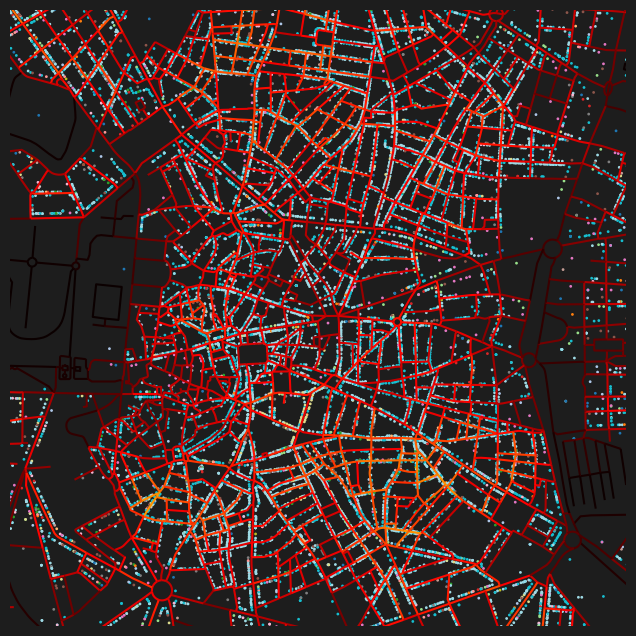

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), facecolor="#1d1d1d")
nodes_gdf.plot(
    column="cc_hill_q0_400_wt",
    cmap="hot",
    legend=False,
    ax=ax,
)
prems_gpd.plot(
    column="division_desc",
    cmap="tab20",
    markersize=1,
    edgecolor=None,
    legend=False,
    ax=ax,
)
ax.set_xlim(439000, 439000 + 2500)
ax.set_ylim(4473000, 4473000 + 2500)
ax.axis(False)
